<a href="https://colab.research.google.com/github/asurovi/MSE504/blob/main/Homework_5_AgnilaGhoshSurovi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSE 504 — Homework 5

**Name: Agnila Ghosh Surovi**

**Department: Mechanical and Aerospace Engineering**

**Date: 9/20/2025**

# Graphene data set

We start with the same graphene data set that we explored in class. Run the full analysis in the notebook below.

## Import

In [2]:
# Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From (original): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
From (redirected): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon&confirm=t&uuid=46ac95ad-8daf-42b3-a9c4-1edad7637848
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:01<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:00<00:00, 110MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 28.6MB/s]


In [3]:
# Installing AtomAI
# It will be used to split the image into local patches centered on atoms

!pip install atomai

In [4]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
import torch
import torch.nn as nn

import seaborn as sns
from scipy import stats

tt = torch.tensor

In [5]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

## Visualization

For the ease of analysis, let's make the movie shorter

Text(0.5, 1.0, 'Atomic coordinates')

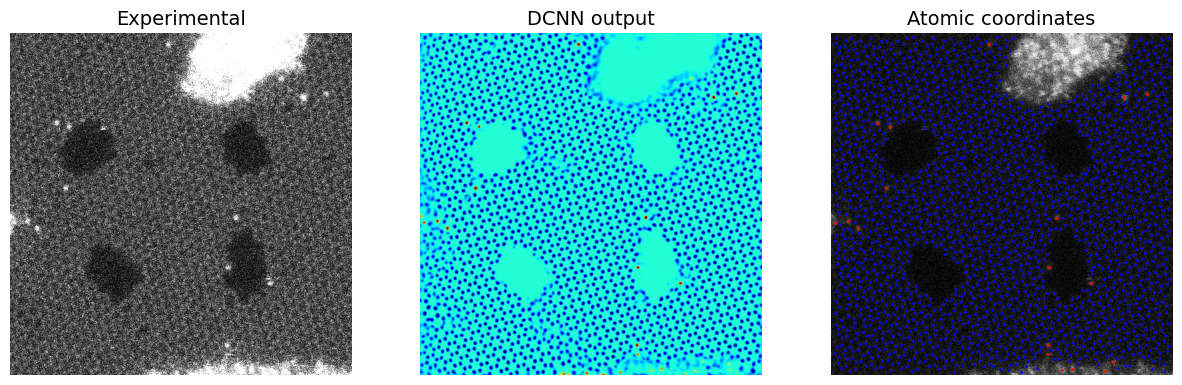

In [6]:
#Vizualizing one frame of the data, we have 50 frames (0-49)

i = 3 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)

# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]

# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

## Creating features

In [7]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below

window_size = 40   # Window_size

s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [8]:
imstack = tt(s.imgstack[:,None,:,:, 0])
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

This code has created three objects. imstack is a collectrion of image patches of the size window_size. The object frames_all contain the information on the frame of the movie from which the image patch has come from. The object com_all contains the information on the coordinates of the patch (i.e. position of the atom that is its center) in the frame.

In [9]:
imstack.shape, frames_all.shape, com_all.shape

(torch.Size([73995, 1, 40, 40]), (73995,), (73995, 2))

In [10]:
np.unique(frames_all)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

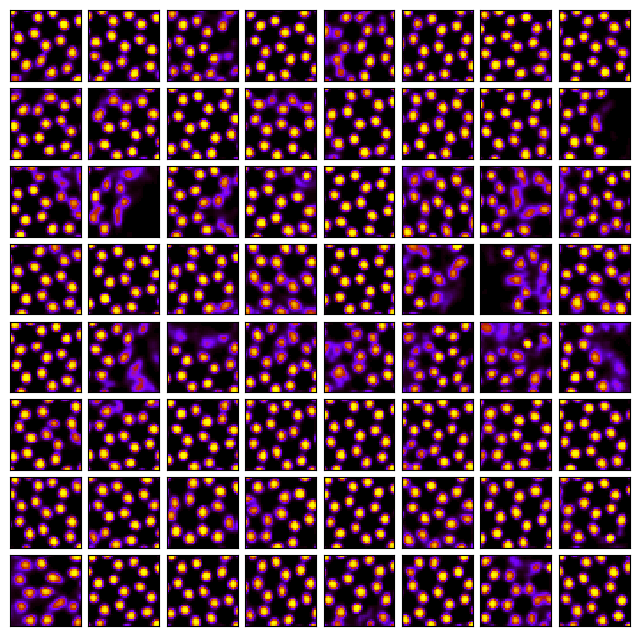

In [11]:
# Vizualizing the training dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

# plt.savefig('example_imgs.png', dpi = 300)

We can check the sizes of all objects we have created

In [12]:
imstack.shape

torch.Size([73995, 1, 40, 40])

Now, we can select the patches and coordinates corresponding only to the first frame.

In [13]:
imstack1 = imstack[frames_all == 1]
com_all1 = com_all[frames_all == 1]
imstack1.shape, com_all1.shape

(torch.Size([1798, 1, 40, 40]), (1798, 2))

## k-means clustering

And run the k-means clustering

In [14]:
from sklearn.cluster import KMeans

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 3
km = KMeans(n_clusters=nc, random_state=0)
y_km = km.fit_predict(imstack2)

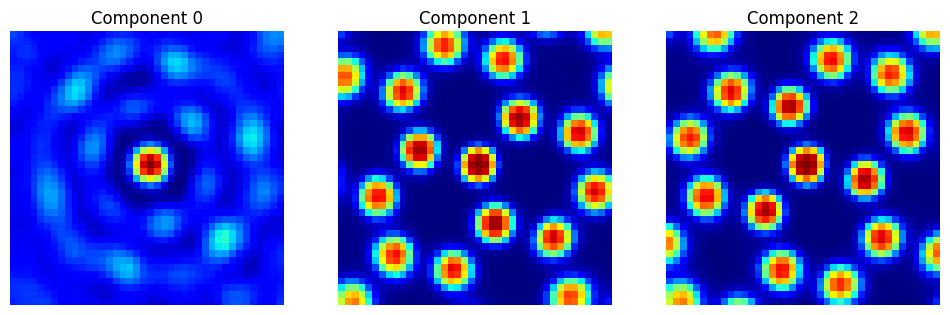

In [15]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(km.cluster_centers_[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

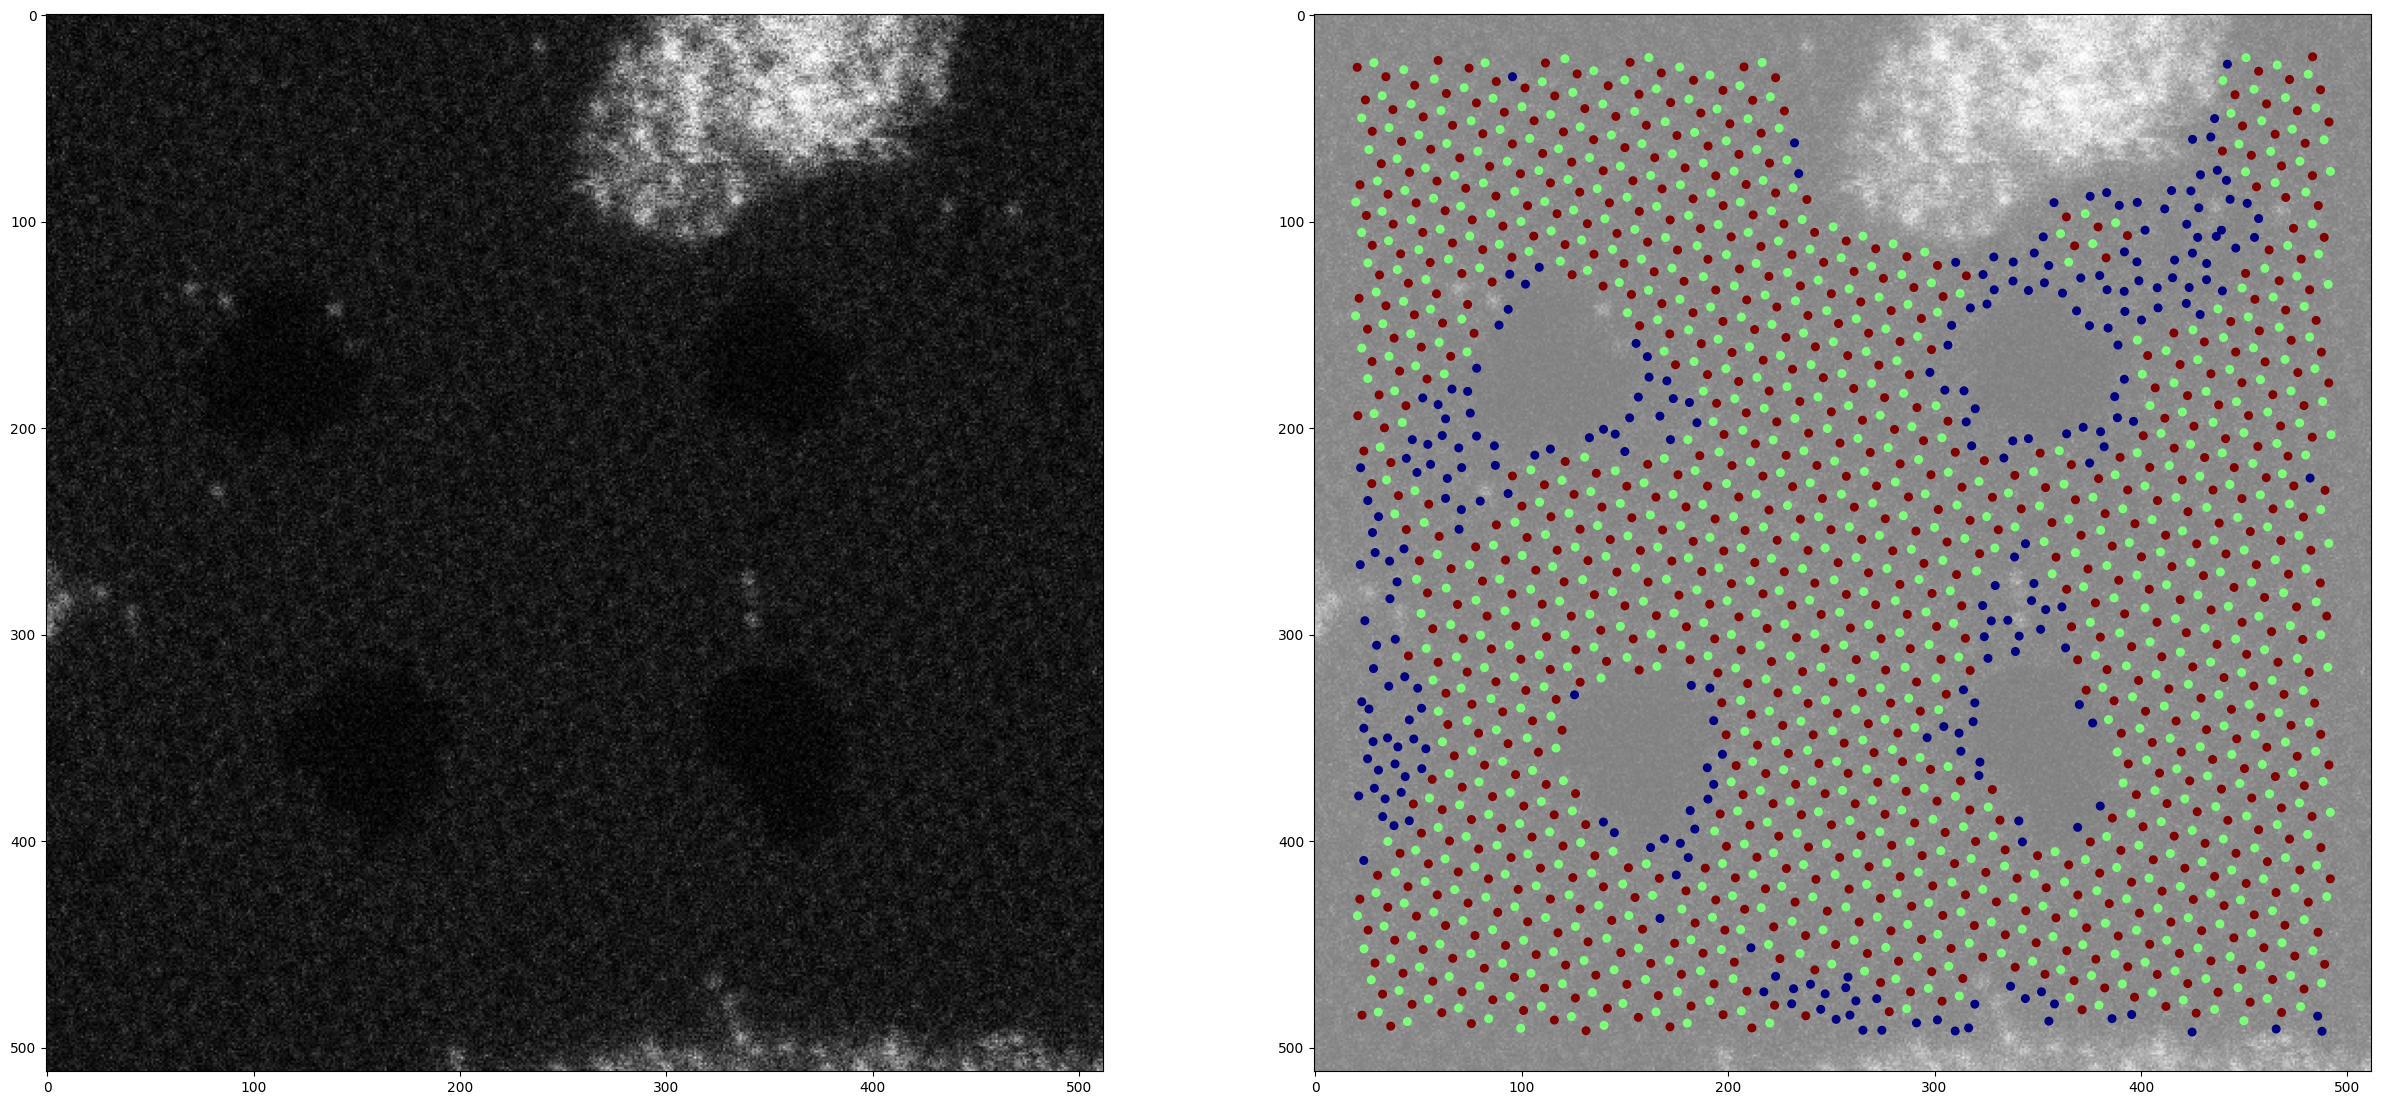

In [16]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=y_km, s=30, cmap="jet")

plt.show()

## GMM clustering

In [17]:
from sklearn.mixture import GaussianMixture as GMM

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 8
gmm = GMM(n_components=nc).fit(imstack2)
gr_labels = gmm.predict(imstack2)
gr_centers = gmm.means_

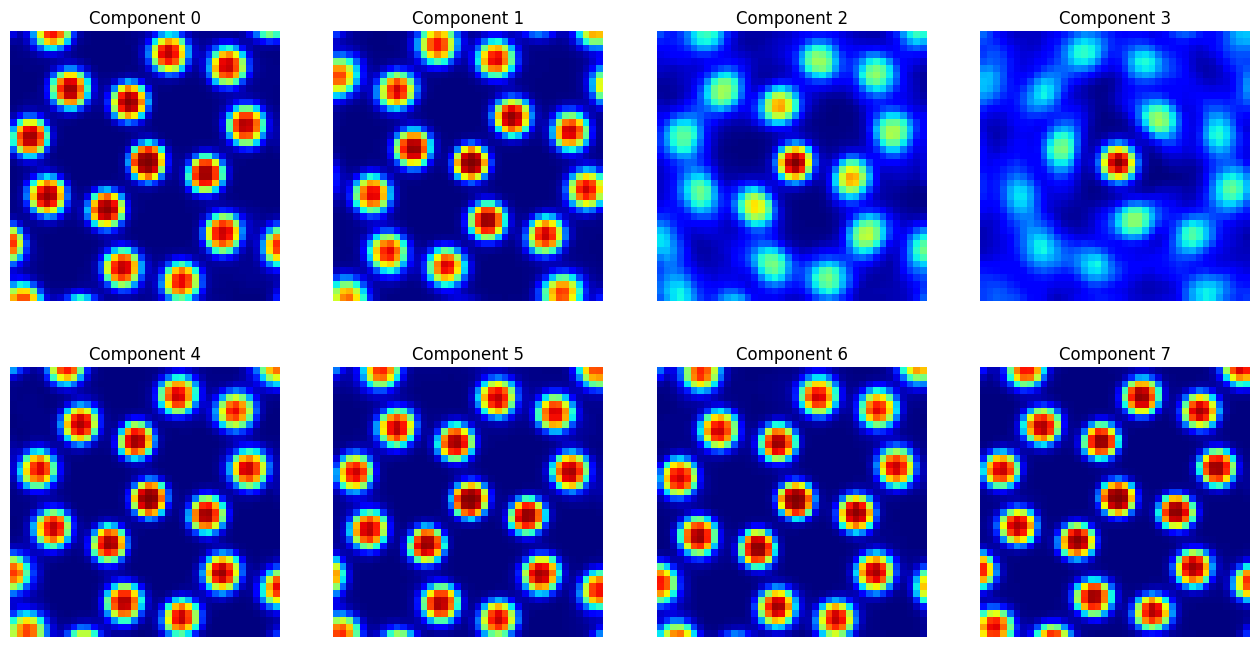

In [18]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(gr_centers[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

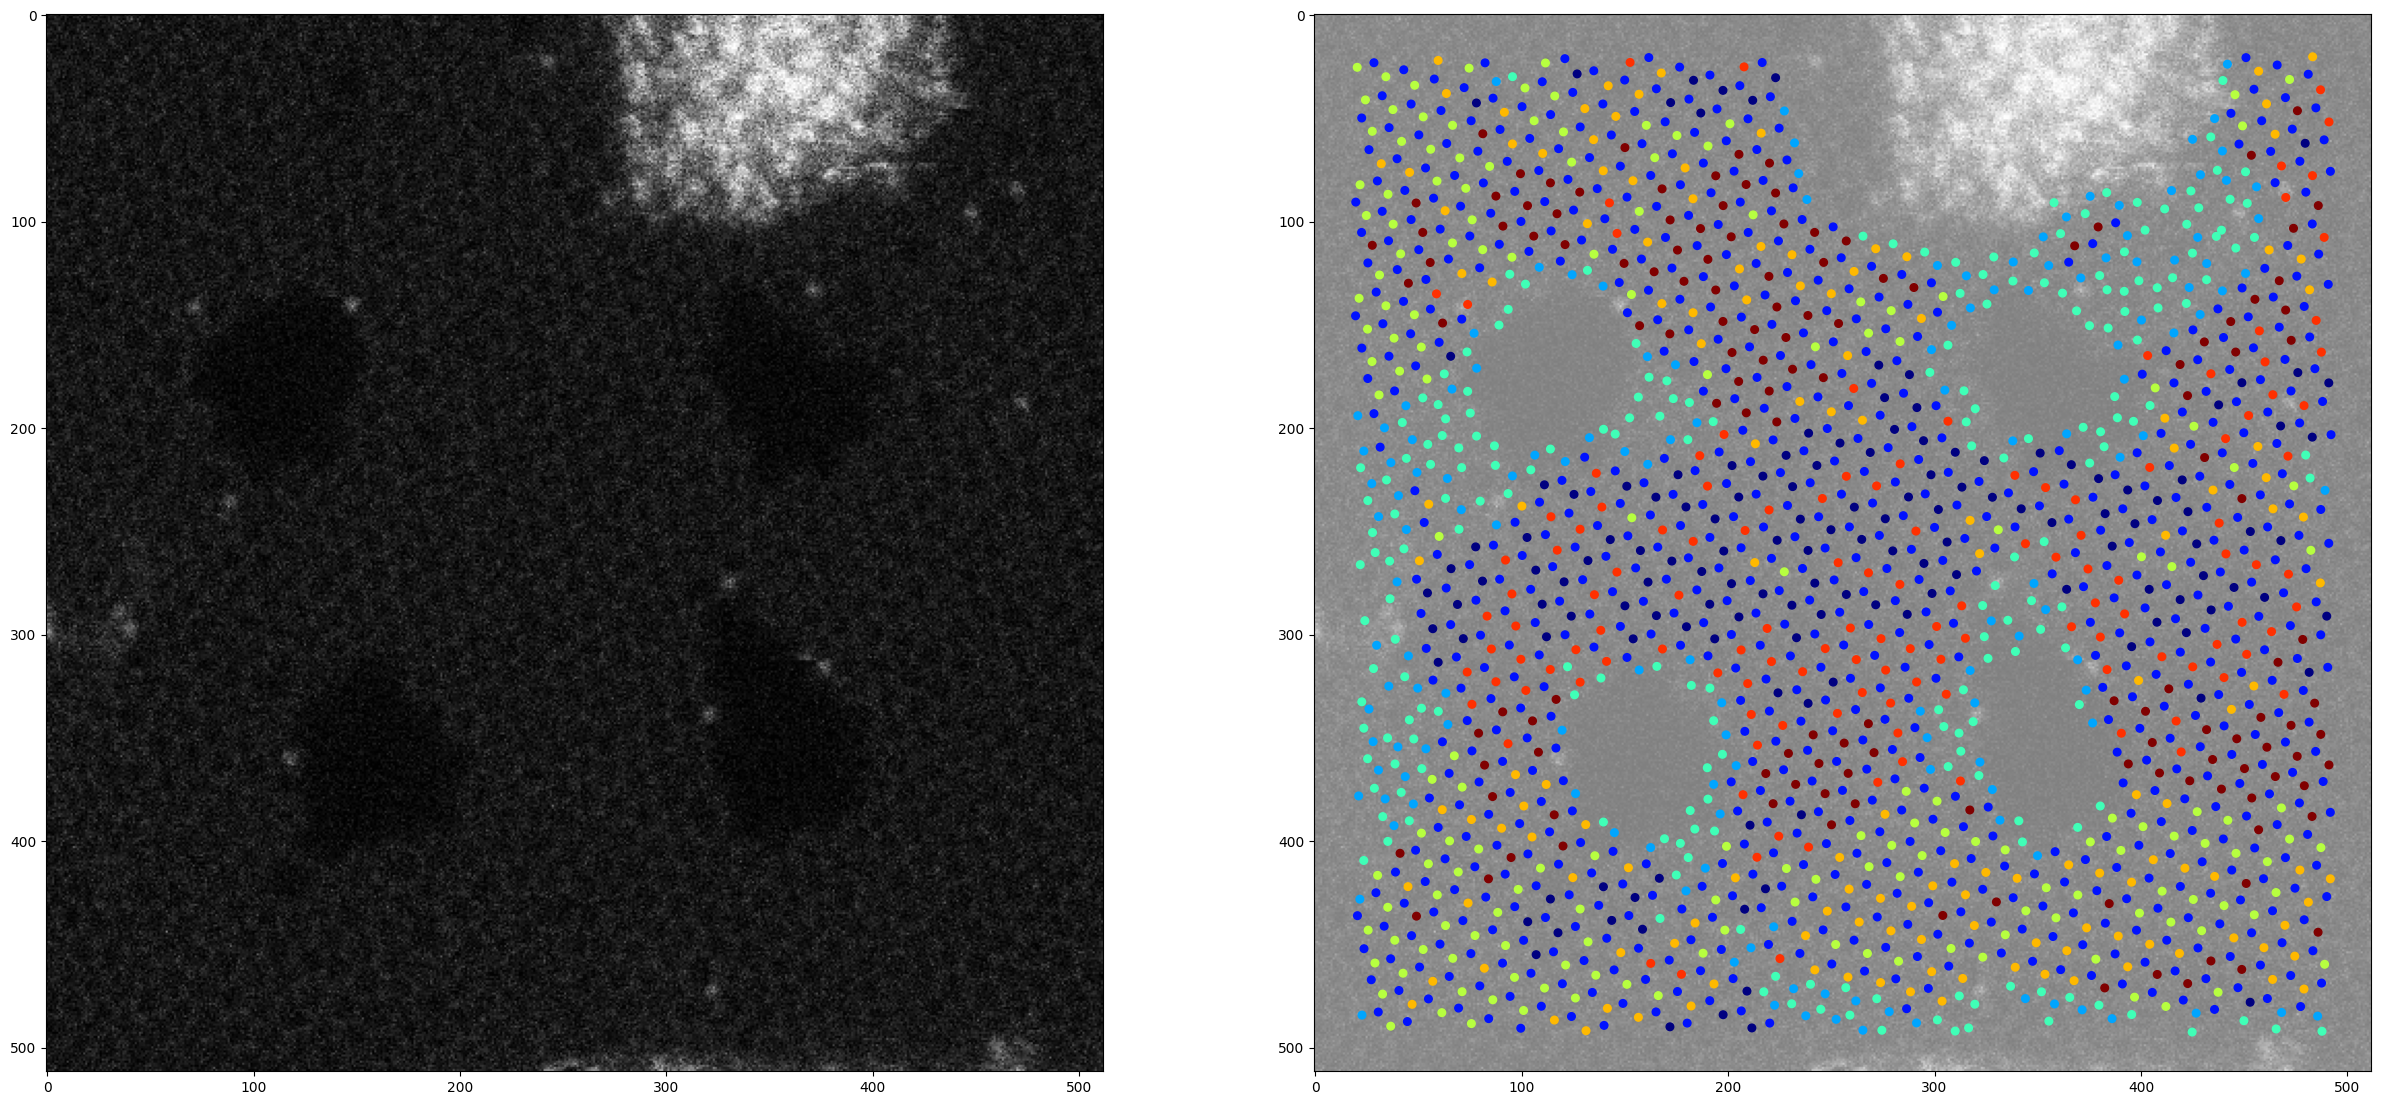

In [19]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=gr_labels, s=30, cmap="jet")

plt.show()

# General comment for homework

Below I provide a set of analyses for Homework 4 using the data above. However, please feel free:
- run this analysis on the EELS data set available in the Notebook 8_Clustering_EELS on https://github.com/SergeiVKalinin/MSE_Fall2023/blob/main/Module%203/8_Clustering_EELS.ipynb
- Or your own dataset as may be relevant to your research. The data set should allow for meaningful classification and clustering
- You can also use different data sets for the two
- use the !gdown method to import the dataset into colab from link (do not use the mounting GDrive option - since I will not be able to access it)

### Download and load EELS data set

In [22]:
!gdown https://drive.google.com/uc?id=1l2yWOReSeeaP7JkFzwtG1LHRCtkebQ5h -O Plasmonic_sets_7222021_fixed.npy


Downloading...
From (original): https://drive.google.com/uc?id=1l2yWOReSeeaP7JkFzwtG1LHRCtkebQ5h
From (redirected): https://drive.google.com/uc?id=1l2yWOReSeeaP7JkFzwtG1LHRCtkebQ5h&confirm=t&uuid=ea180bca-355f-469f-894d-1543f111505b
To: /content/Plasmonic_sets_7222021_fixed.npy
100% 1.13G/1.13G [00:09<00:00, 120MB/s]


In [23]:
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

In [24]:
loadedfile.keys()


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [25]:
data = loadedfile['1']
print(type(data))
print(data.keys())


<class 'dict'>
dict_keys(['image', 'spectrum image', 'energy axis', 'scale'])


In [26]:
cube = data['spectrum image']
print("Spectrum image shape:", cube.shape)


Spectrum image shape: (25, 79, 3661)


In [27]:
nx, ny, nE = cube.shape
X = cube.reshape(-1, nE)

# Homework Part I

1. Calculate the elbow curve for the k-means analysis above

## Answer 1:

### Graphene data set

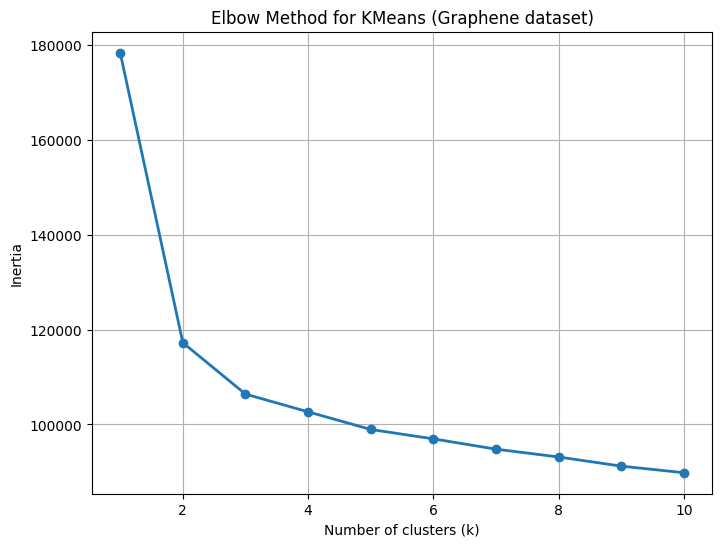

In [20]:
inertias = []
K_range = range(1, 11)  # test k = 1 to 10

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(imstack2)        # imstack2 is your flattened patches
    inertias.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'o-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans (Graphene dataset)")
plt.grid(True)
plt.show()

### EELS data set

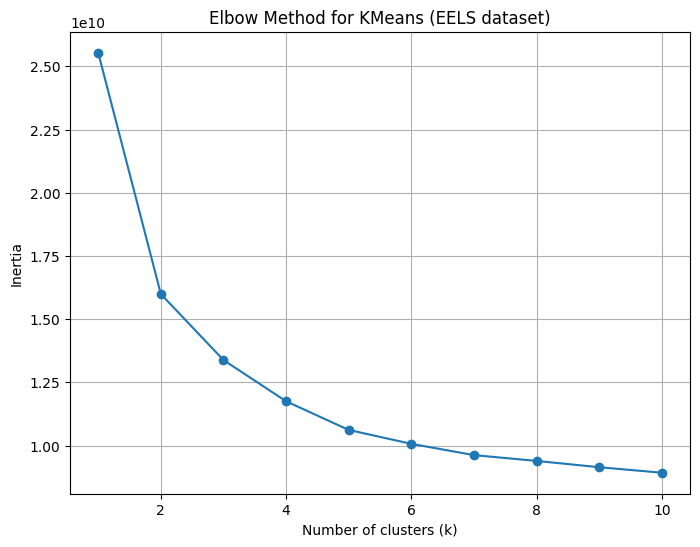

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

K_range = range(1, 11)   # test k = 1 to 10
inertias = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=5)
    km.fit(X)                 # X is your reshaped EELS spectra
    inertias.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K_range, inertias, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans (EELS dataset)")
plt.grid(True)
plt.show()


* **For the graphene dataset, the elbow occurs at k ≈ 3**, indicating three distinct groups of atomic patches.

* **For the EELS dataset**, the inertia decreases steeply up to k = 3–4, after which the curve flattens. Thus, **the optimal number of clusters is around 3 or 4**, suggesting that the spectral data can be grouped into a small number of distinct classes.

2. Calculate the silhoutte for the k-means (or GMM - up to you)  for different number of clusters. Determine that optimal number of clusters for this data set and method.

## Answer 2:

### Graphene data set


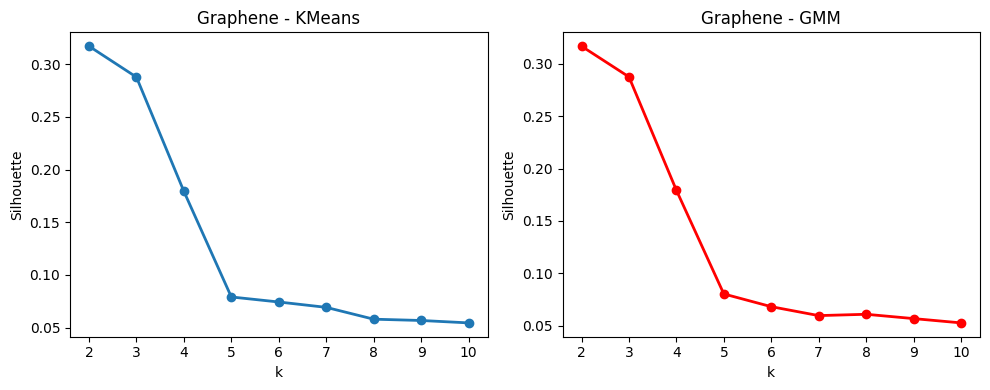

Graphene best k (KMeans): 2
Graphene best k (GMM): 2


In [21]:
from sklearn.metrics import silhouette_score

# Graphene: imstack2 = flattened patches
Xg = imstack2

K_range = range(2, 11)
sil_kmeans, sil_gmm = [], []

# KMeans silhouette
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=5)
    labels = km.fit_predict(Xg)
    sil_kmeans.append(silhouette_score(Xg, labels))

# GMM silhouette
for k in K_range:
    gmm = GMM(n_components=k, covariance_type='full',
                          reg_covar=1e-6, max_iter=300, random_state=0)
    labels = gmm.fit_predict(Xg)
    sil_gmm.append(silhouette_score(Xg, labels))

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, sil_kmeans, 'o-', lw=2)
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Graphene - KMeans")

plt.subplot(1,2,2)
plt.plot(K_range, sil_gmm, 'o-', lw=2, color='red')
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Graphene - GMM")

plt.tight_layout(); plt.show()

print("Graphene best k (KMeans):", K_range[np.argmax(sil_kmeans)])
print("Graphene best k (GMM):", K_range[np.argmax(sil_gmm)])

**The silhouette analysis of graphene datasets gave the highest score at k = 2**, which suggests the data can be cleanly separated into two groups. However, **the elbow curve shows a clear bend at k = 3**, and **physically the graphene dataset is expected to contain three distinct classes: C atoms, Si atoms, and background regions**.

Therefore, **while k = 2 maximizes the silhouette score, k = 3 provides a more meaningful clustering in the context of the data**, since it aligns with the physical structure of the sample.

### EELS data set

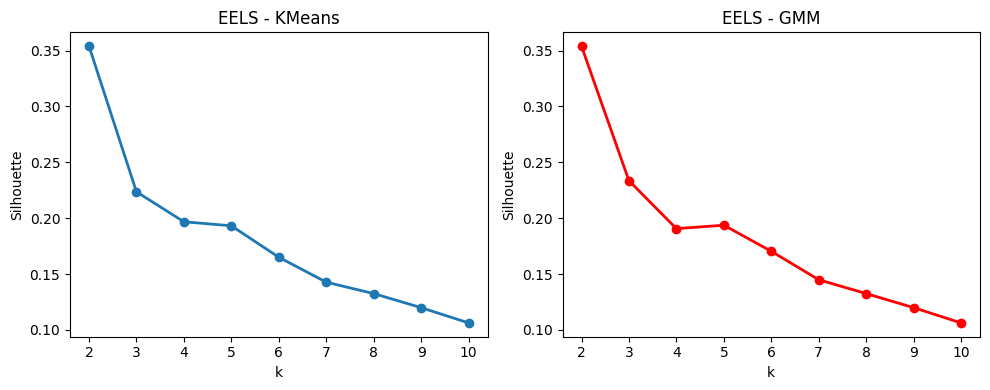

EELS best k (KMeans): 2
EELS best k (GMM): 2


In [31]:
# EELS: X = cube.reshape(-1, nE)
Xe = X   # (n_pixels, n_channels)

K_range = range(2, 11)
sil_kmeans, sil_gmm = [], []

# KMeans silhouette
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=5)
    labels = km.fit_predict(Xe)
    sil_kmeans.append(silhouette_score(Xe, labels))

# GMM silhouette
for k in K_range:
    gmm = GMM(n_components=k, covariance_type='full',
                          reg_covar=1e-6, max_iter=300, random_state=0)
    labels = gmm.fit_predict(Xe)
    sil_gmm.append(silhouette_score(Xe, labels))

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, sil_kmeans, 'o-', lw=2)
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("EELS - KMeans")

plt.subplot(1,2,2)
plt.plot(K_range, sil_gmm, 'o-', lw=2, color='red')
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("EELS - GMM")

plt.tight_layout(); plt.show()

print("EELS best k (KMeans):", K_range[np.argmax(sil_kmeans)])
print("EELS best k (GMM):", K_range[np.argmax(sil_gmm)])


3. Repeat this analysis for several wondow sizes (10, 20, 40, 60, 80). What is the optimal number of clusters for each of these window size? Rationalize these observations

## Answer 3:

In [23]:
import numpy as np, torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import atomai as aoi

# --- choose the SAME frame you used before (e.g., 3) ---
i0 = 3

# fix randomness
np.random.seed(0)
torch.manual_seed(0)

window_sizes = [10, 20, 40, 60, 80]
K_range = range(2, 7)  # 2..6 is usually enough and faster
results = {}

for ws in window_sizes:
    # Build patches across ALL frames
    s_ws = aoi.stat.imlocal(np.sum(decoded_imgs[..., :-1], -1)[..., None],
                            lattice_coord, ws, 0)
    # Filter to the single frame i0 to match your earlier analysis
    frames = s_ws.imgstack_frames
    sel = (frames == i0)

    # Shape: (N_patches, H, W, 1) in s_ws.imgstack[..., 0]
    imstack_ws = s_ws.imgstack[sel, :, :, 0]     # -> (n, H, W)
    n, H, W = imstack_ws.shape
    X = imstack_ws.reshape(n, H*W)

    # scale features (important for stability)
    Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

    sil_scores = []
    for k in K_range:
        km = KMeans(n_clusters=k,
                    random_state=0,
                    n_init=20,          # higher for stability
                    max_iter=300,
                    algorithm='elkan')  # faster & stable for Euclidean
        labels = km.fit_predict(Xz)

        # full silhouette on this frame’s patches (no subsample)
        score = silhouette_score(Xz, labels)
        sil_scores.append(score)

    best_k = list(K_range)[int(np.argmax(sil_scores))]
    results[ws] = {"best_k": best_k, "sil_scores": sil_scores}

print("Window size  ->  Best k (by silhouette, fixed frame & seeds)")
for ws in window_sizes:
    print(f"{ws:>11}  ->  {results[ws]['best_k']}")


Window size  ->  Best k (by silhouette, fixed frame & seeds)
         10  ->  2
         20  ->  5
         40  ->  3
         60  ->  2
         80  ->  2


4. In class, we have explored the density based clustering tehcniques. Following the GMM and k-means clustering analysis above, run the same analysis using the density based clustering.

## Answer 4:

DBSCAN found 2 clusters
Silhouette score: -0.11608215


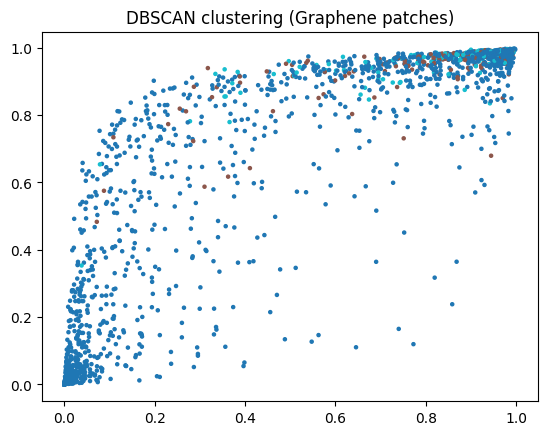

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use imstack2 (Graphene patches) or imstack_ws2 for a chosen window size
Xg = imstack2  # flattened patches from graphene

# DBSCAN parameters (tune eps and min_samples)
db = DBSCAN(eps=5, min_samples=10).fit(Xg)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("DBSCAN found", n_clusters, "clusters")

# Silhouette score (only if more than 1 cluster)
if n_clusters > 1:
    score = silhouette_score(Xg, labels)
    print("Silhouette score:", score)

# Plot cluster labels (optional)
plt.scatter(Xg[:,0], Xg[:,1], c=labels, cmap='tab10', s=5)
plt.title("DBSCAN clustering (Graphene patches)")
plt.show()


**Applying DBSCAN to the graphene dataset (patch-based features) yields 2 clusters**. However, **the silhouette score is negative (–0.11), indicating poor cluster separation**. Most points were grouped into one large cluster, while a few formed a small second cluster. Compared to KMeans/GMM, which produced meaningful 2–3 clusters corresponding to atomic species and background, DBSCAN performed poorly. **This suggests that density-based clustering is less effective for this high-dimensional dataset without dimensionality reduction (e.g., PCA) or careful parameter tuning**.

5. When exploring the analysis for window_size = 40, you will note that symmetry non-equivalent carbon atoms in sp2 configuration are classified into different groups. However, chemically these are equivalent. Suggest potential approach to avoid this problem.

## Answer 5:

In the 40-pixel window size, symmetry-equivalent carbon atoms are split into different groups because the clustering picks up orientation differences in the image patches. **To avoid this, one can enforce rotational invariance, for example by aligning each patch to a common bond direction before clustering, or by using rotation-invariant descriptors (e.g., radial profiles or Zernike moments)**. This ensures that chemically equivalent sp² carbon atoms are placed in the same cluster.

6 (Optional - if well familiar with Python and want a challenge). Realize this approach

## Answer 6:

### A) Align every patch to a common orientation, then cluster

In [25]:
import numpy as np, cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# --- choose a set of patches, e.g., frame 1 only (imstack1) or all (imstack) ---
# If you already have imstack1 for frame 1:
X_raw = imstack1[:, 0].cpu().numpy() if hasattr(imstack1, "cpu") else imstack1[:, 0].numpy() if hasattr(imstack1, "numpy") else imstack1[:, 0]
# X_raw shape: (N, H, W)

def normalize_intensity(img):
    m, s = img.mean(), img.std() + 1e-8
    return (img - m) / s

def estimate_angle(img, r_in=4, r_out=12):
    """
    Estimate local bond direction around center using image moments (PCA on gradient).
    Simple & fast: compute gradients, take orientation of dominant eigenvector.
    """
    H, W = img.shape
    y0, x0 = H//2, W//2
    # circular mask to focus near the atom
    Y, X = np.ogrid[:H, :W]
    R2 = (Y - y0)**2 + (X - x0)**2
    mask = (R2 >= r_in**2) & (R2 <= r_out**2)

    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gx, gy = gx[mask], gy[mask]

    # structure tensor
    Sxx = np.dot(gx, gx)
    Syy = np.dot(gy, gy)
    Sxy = np.dot(gx, gy)
    M = np.array([[Sxx, Sxy],[Sxy, Syy]])
    vals, vecs = np.linalg.eigh(M)
    v = vecs[:, np.argmax(vals)]  # dominant direction
    angle = np.degrees(np.arctan2(v[1], v[0]))
    return angle

def align_patch(img):
    img = normalize_intensity(img.astype(np.float32))
    # subpixel recentre (optional): shift by COM so atom is centered
    H, W = img.shape
    y, x = np.indices(img.shape)
    com_y = (y * (img - img.min() + 1e-6)).sum() / ((img - img.min() + 1e-6).sum())
    com_x = (x * (img - img.min() + 1e-6)).sum() / ((img - img.min() + 1e-6).sum())
    dy, dx = (H/2 - com_y), (W/2 - com_x)
    M_shift = np.float32([[1, 0, dx],[0, 1, dy]])
    img = cv2.warpAffine(img, M_shift, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    # estimate and snap orientation to canonical (e.g., 0° modulo 60° for graphene)
    ang = estimate_angle(img)
    # snap to nearest 60° sector to enforce hex symmetry
    snapped = np.round(ang / 60.0) * 60.0
    M_rot = cv2.getRotationMatrix2D((W/2, H/2), snapped, 1.0)
    img = cv2.warpAffine(img, M_rot, (W, H), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)

    # final normalize
    return normalize_intensity(img)

# Align all patches
X_aligned = np.stack([align_patch(p) for p in X_raw], axis=0)   # (N, H, W)
X_flat = X_aligned.reshape(len(X_aligned), -1)

# Scale & cluster
Xz = StandardScaler().fit_transform(X_flat)
K_range = range(2, 6)
scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=20, algorithm='elkan')
    labels = km.fit_predict(Xz)
    scores.append(silhouette_score(Xz, labels))
best_k = list(K_range)[int(np.argmax(scores))]
print("Aligned patches → best k by silhouette:", best_k)


Aligned patches → best k by silhouette: 3


### Use rotation-invariant features (radial profiles), then cluster

In [26]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# X_raw as above: (N, H, W)
def radial_profile(img, n_bins=20, r_max=None):
    H, W = img.shape
    y0, x0 = H//2, W//2
    Y, X = np.indices(img.shape)
    R = np.sqrt((Y - y0)**2 + (X - x0)**2)
    if r_max is None:
        r_max = min(H, W)/2 - 1
    r = R.flatten()
    v = img.flatten()
    edges = np.linspace(0, r_max, n_bins+1)
    prof = np.zeros(n_bins, dtype=np.float32)
    for i in range(n_bins):
        sel = (r >= edges[i]) & (r < edges[i+1])
        prof[i] = v[sel].mean() if np.any(sel) else 0.0
    # normalize profile
    m, s = prof.mean(), prof.std() + 1e-8
    return (prof - m)/s

# Build rotation-invariant descriptors
profiles = np.stack([radial_profile(p.astype(np.float32), n_bins=24) for p in X_raw], axis=0)  # (N, 24)
Xz = StandardScaler().fit_transform(profiles)

# Cluster & pick k
K_range = range(2, 6)
scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=20, algorithm='elkan')
    labels = km.fit_predict(Xz)
    scores.append(silhouette_score(Xz, labels))
best_k = list(K_range)[int(np.argmax(scores))]
print("Radial (rotation-invariant) features → best k by silhouette:", best_k)


Radial (rotation-invariant) features → best k by silhouette: 2


7. (Optional - if well familiar with Python and want a challenge). Analyze the stack of images using k-means clustering and plot the evolution of cluster fractions as a function of time.

## Answer 7:

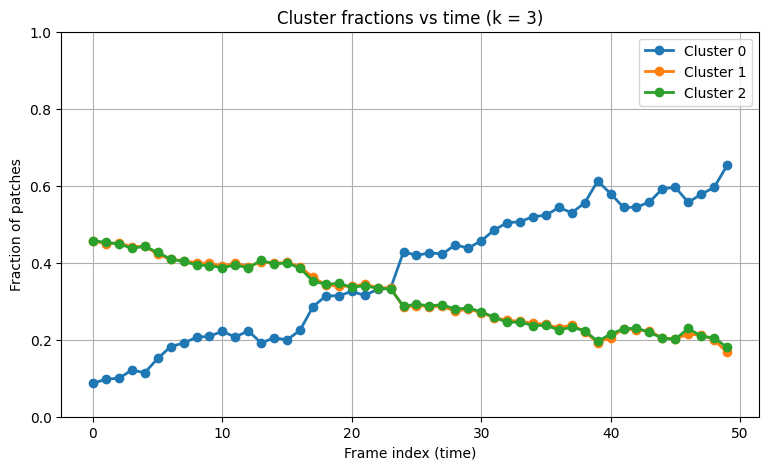

In [27]:
# --- (Recreate if needed) ---
# import numpy as np, torch, atomai as aoi
# s = aoi.stat.imlocal(np.sum(decoded_imgs[..., :-1], -1)[..., None], lattice_coord, window_size=40, min_distance=0)
# imstack = torch.tensor(s.imgstack[:, None, :, :, 0])   # (N,1,H,W)
# frames_all = s.imgstack_frames                         # (N,)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Prepare features for all patches (flatten each patch)
N, C, H, W = imstack.shape
X = imstack.reshape(N, H*W).cpu().numpy() if hasattr(imstack, "cpu") else imstack.reshape(N, H*W)
frames = np.array(frames_all)  # shape (N,)

# 2) (Recommended) standardize features
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# 3) Choose number of clusters (use what you decided earlier; 3 is common)
k = 3  # change to your preferred k

# 4) K-Means on all patches
km = KMeans(n_clusters=k, n_init=20, random_state=0, algorithm='elkan')
labels = km.fit_predict(Xz)   # shape (N,)

# 5) Compute per-frame cluster fractions
n_frames = frames.max() + 1   # assuming frames are 0..F-1
fractions = np.zeros((n_frames, k), dtype=float)

for f in range(n_frames):
    sel = (frames == f)
    if sel.sum() == 0:
        continue
    counts = np.bincount(labels[sel], minlength=k).astype(float)
    fractions[f, :] = counts / counts.sum()

# 6) Plot: evolution of cluster fractions over time (frame index)
plt.figure(figsize=(9,5))
for c in range(k):
    plt.plot(range(n_frames), fractions[:, c], marker='o', linewidth=2, label=f'Cluster {c}')
plt.xlabel('Frame index (time)')
plt.ylabel('Fraction of patches')
plt.title(f'Cluster fractions vs time (k = {k})')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


KMeans clustering are applied to all atomic patches from the movie stack. For each frame, the fraction of patches belonging to each cluster are being computed. The resulting plot shows how cluster fractions evolve with time, reflecting changes in atomic environments during the experiment

# Homework Part II

After running the analysis in the previous sections, we now have access to the k-means clustering results of the image patches. Effectively, each atom in the image is now associated with the patch centered on this atom, and the cluster label. The y_km is a label array, and km.cluster_centers_ is the centroid of the clustes. Remember that you need to reshape it back to (window_size, window_size) in order to get the image. We also have access to the imstack2 object, which is a collection of all patches, and com_all1 object that contains the information on the coordinate from which the patch has come from.

In [28]:
y_km.shape, km.cluster_centers_.shape, imstack2.shape, com_all1.shape

((1798,), (3, 1600), torch.Size([1798, 1600]), (1798, 2))

8. Create a X,y data set for a classification problem. Here, the image is a feature, and the cluster label is assumed to be known ground truth label (alternatively, we can do manual labelling, but for the purpose of excercise let's assume that ground truth labels are already known).

## Answer 8:

In [29]:
import numpy as np

# X = image features
X = imstack2   # already flattened: shape (N_samples, H*W)

# y = labels (ground truth from KMeans clustering)
y = y_km       # shape (N_samples,)

print("Feature matrix X:", X.shape)
print("Labels y:", y.shape)


Feature matrix X: torch.Size([1798, 1600])
Labels y: (1798,)


A classification dataset are being constructed where each image patch is used as a feature and the cluster label is treated as the ground truth. The feature matrix 𝑋 has shape (1798, 1600), corresponding to 1,798 patches, each flattened from a 40×40 image. The label array 𝑦 has shape (1798,), containing the KMeans cluster assignments for each patch.

9. Use the train_test_split function to create the training set and test set for classification problem.

## Answer 9:

In [30]:
from sklearn.model_selection import train_test_split

# X = (1798, 1600), y = (1798,)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

print("Training set X_train:", X_train.shape)
print("Test set X_test:", X_test.shape)
print("Training labels y_train:", y_train.shape)
print("Test labels y_test:", y_test.shape)


Training set X_train: torch.Size([1438, 1600])
Test set X_test: torch.Size([360, 1600])
Training labels y_train: (1438,)
Test labels y_test: (360,)


The dataset is splited into training and testing subsets using train_test_split. With 20% of the data reserved for testing, the training set contained 1,438 samples and the test set contained 360 samples. Stratification ensured that the class proportions remained consistent between the training and test sets.

10. Run the logistics classification on the data and plot the confucion matrix and ROC curve

## Answer 10:

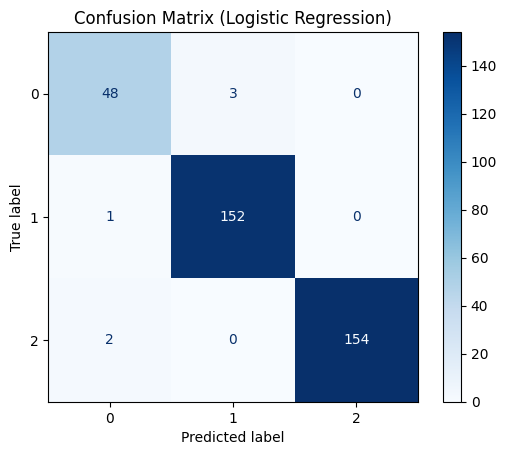

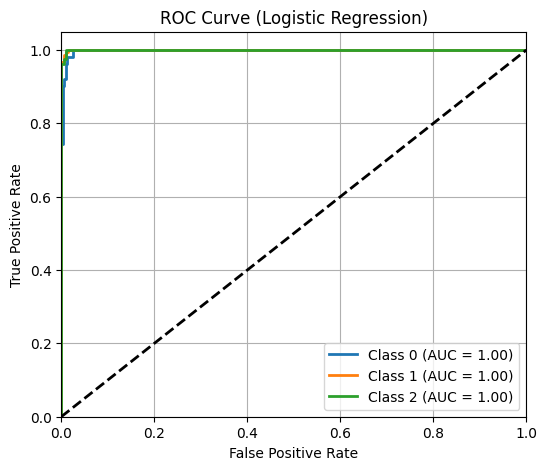

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1) Train logistic regression
clf = LogisticRegression(max_iter=1000, random_state=0)
clf.fit(X_train, y_train)

# 2) Predict on test set
y_pred = clf.predict(X_test)

# 3) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# 4) ROC curve (multi-class)
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = clf.decision_function(X_test)

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


A logistic regression classifier is trained on the training set (1438 samples) and evaluated it on the test set (360 samples). The confusion matrix shows how predictions compare to the true cluster labels. The ROC curves demonstrate classifier performance across classes, with area-under-curve (AUC) values indicating the separability of each class.

11. Run the CART classification on the data and plot the decision tree and ROC curve. Is this analysis meaningful?

## Answer 11:

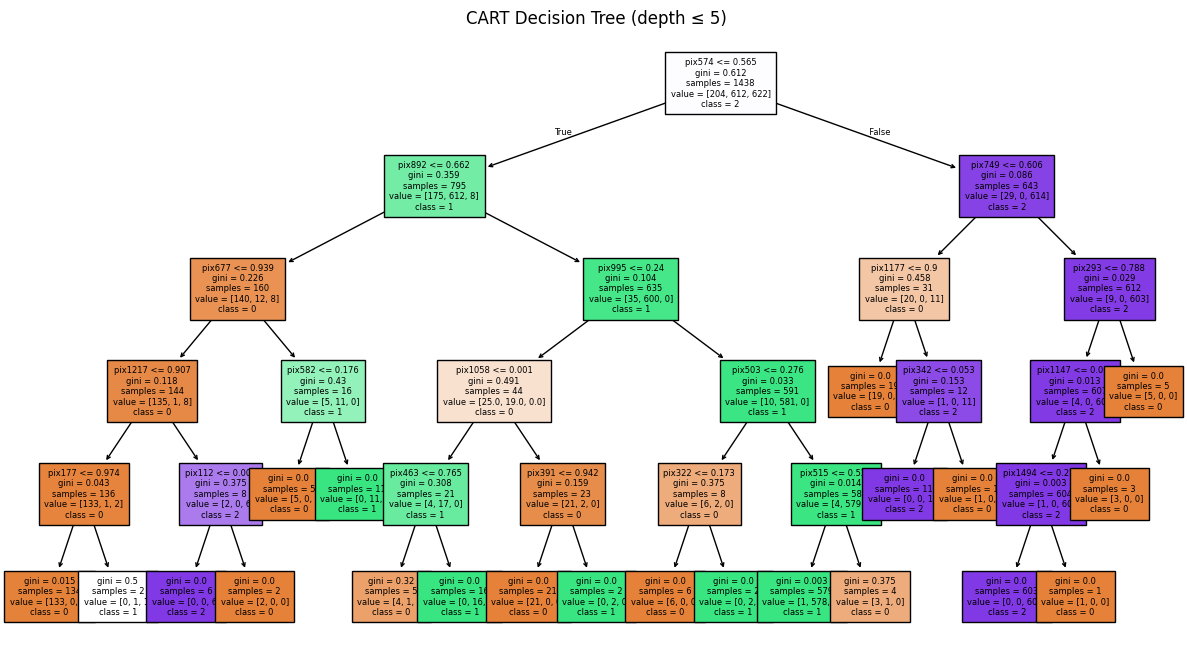

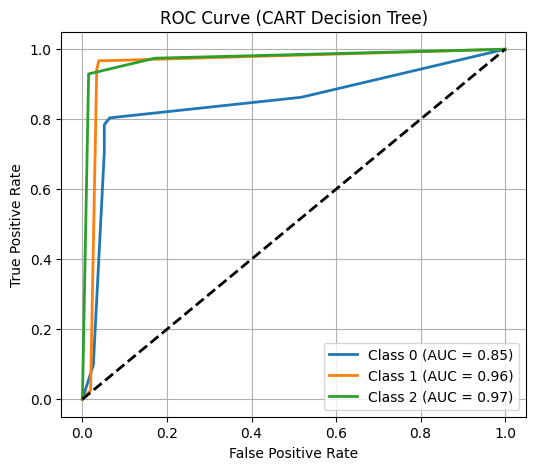

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1) Train CART decision tree
cart = DecisionTreeClassifier(max_depth=5, random_state=0)  # limit depth for clarity
cart.fit(X_train, y_train)

# 2) Plot the decision tree (small trees only!)
plt.figure(figsize=(15, 8))
plot_tree(cart,
          feature_names=[f"pix{i}" for i in range(X_train.shape[1])],
          class_names=[str(c) for c in np.unique(y)],
          filled=True, fontsize=6)
plt.title("CART Decision Tree (depth ≤ 5)")
plt.show()

# 3) ROC curve for CART
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = cart.predict_proba(X_test)

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (CART Decision Tree)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


A CART classifier is being trained (Decision Tree) on the patch dataset. The tree structure is visualized with plot_tree, and ROC curves are computed.

**While the classifier could achieve some separation of classes, the analysis is not very meaningful.**
* Decision trees tend to overfit high-dimensional data such as flattened images, and the resulting model does not generalize well.
*Logistic regression (and other linear models) provide a more robust and interpretable classification for this dataset.

12. Run the XGBoost classification on the dataset and plot the ROC curve.

## Answer 12:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:49:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


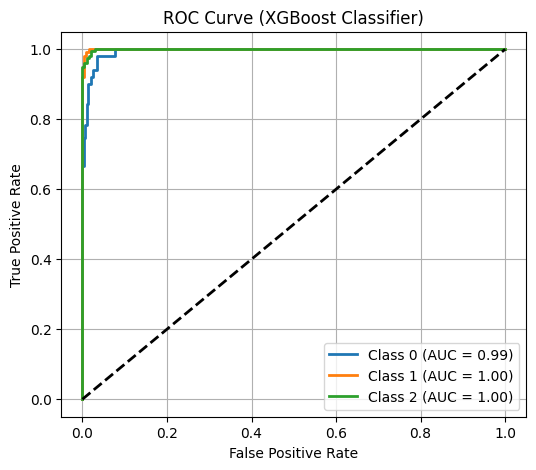

In [33]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1) Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,       # number of trees
    max_depth=6,           # depth of each tree
    learning_rate=0.1,     # shrinkage
    subsample=0.8,         # random sampling for robustness
    colsample_bytree=0.8,  # feature sampling
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=0
)
xgb_clf.fit(X_train, y_train)

# 2) Predict probabilities for ROC
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = xgb_clf.predict_proba(X_test)

# 3) Plot ROC curve
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


An XGBoost classifier is being trained on the dataset. The ROC curves shows improved performance compared to logistic regression and single CART models, with higher AUC values across classes. This indicates that boosted ensembles of trees can capture more complex relationships in the image features, although interpretability is reduced compared to simpler models.